In [1]:
%load_ext autoreload
%autoreload 2

In [2]:

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from statsmodels.stats.diagnostic import het_arch

from sklearn.linear_model import LinearRegression

In [60]:
from proj.data.load import load_ibkr_prices, load_macro_series
from proj.utils.dates import duration_to_dates
from proj.features import transforms
from proj.evaluation.backtesting import rolling_forecast_backtest, evaluate_performance, ts_hyperparam_search
from proj.features.feature_selection import greedy_feature_selection

from proj.models.garch import GARCHRegressor
from proj.models.arima import ARIMA_RV_Model
from proj.models.xgb import XGBRVModel

In [4]:
plt.style.use("styler.mplstyle") 

In [5]:
DURATION = "10 Y"        # hyperparameter
END_DATE = None 

START_DATE, END_DATE = duration_to_dates(DURATION, end=END_DATE)
START_DATE, END_DATE

(datetime.date(2015, 11, 18), datetime.date(2025, 11, 18))

## Pre Processing

In [6]:

# Monthly
# macro = [
#     'CPIAUCSL',   # CPI (All Urban Consumers)
#     'INDPRO',     # Industrial Production Index
#     'CNP16OV',    # Civilian Noninstitutional Population, 16+
#     'FEDFUNDS',   # Effective Federal Funds Rate
#     'UNRATE'      # Unemployment Rate
# ]

# Daily
macro = [
    'VIXCLS',        # Implied equity vol
    'EFFR',          # Fed Fund rate (daily)
    'DGS2',          # 2-year Treasury yield
    'DGS10',         # 10-year Treasury yield
    'TEDRATE',       # Funding stress
    'DCOILWTICO',    # Crude oil spot
    'DHHNGSP',       # Natural gas
    'DEXUSEU',       # USD/EUR
]

In [7]:

macro_series = load_macro_series(macro, START_DATE, END_DATE)

In [8]:
macro_series

,DATE,VIXCLS,EFFR,DGS2,DGS10,TEDRATE,DCOILWTICO,DHHNGSP,DEXUSEU
0,2015-11-18,16.85,0.12,0.90,2.27,0.25,40.75,2.10,1.0638
1,2015-11-19,16.99,0.12,0.91,2.24,0.27,40.55,2.10,1.0746
2,2015-11-20,15.47,0.12,0.93,2.26,0.27,39.39,2.18,1.0660
3,2015-11-23,15.62,0.12,0.94,2.25,0.25,39.27,2.18,1.0602
4,2015-11-24,15.93,0.12,0.93,2.24,0.24,40.89,2.14,1.0652
...,...,...,...,...,...,...,...,...,...
2604,2025-11-11,17.28,3.87,3.58,4.13,0.09,60.94,3.80,1.1545
2605,2025-11-12,17.51,3.87,3.56,4.08,0.09,60.94,3.80,1.1592
2606,2025-11-13,20.00,3.88,3.58,4.11,0.09,60.94,3.80,1.1649
2607,2025-11-14,19.83,3.88,3.62,4.14,0.09,60.94,3.80,1.1617


In [9]:
stock_data = [
    'XLE',
    'SPY',
    # Crude Oil 
    ]

In [10]:
stock_series = await load_ibkr_prices(stock_data, DURATION)

Connected to Interactive Brokers successfully.


In [11]:
stock_series

,date,SPY,XLE
0,2015-11-23,209.07,67.38
1,2015-11-24,209.35,68.82
2,2015-11-25,209.32,68.26
3,2015-11-27,209.56,67.77
4,2015-11-30,208.69,68.02
...,...,...,...
2507,2025-11-12,683.38,90.25
2508,2025-11-13,672.04,90.48
2509,2025-11-14,671.93,92.02
2510,2025-11-17,665.67,90.34


In [12]:
stock_series['XLE_r'] = transforms.log_returns(stock_series, 'XLE')
stock_series['SPY_r'] = transforms.log_returns(stock_series, 'SPY')

In [13]:
df = stock_series.merge(macro_series, left_on='date', right_on=['DATE']).drop(columns=['date'])

In [14]:
df.dropna(inplace=True)

#### Stock and Indicators

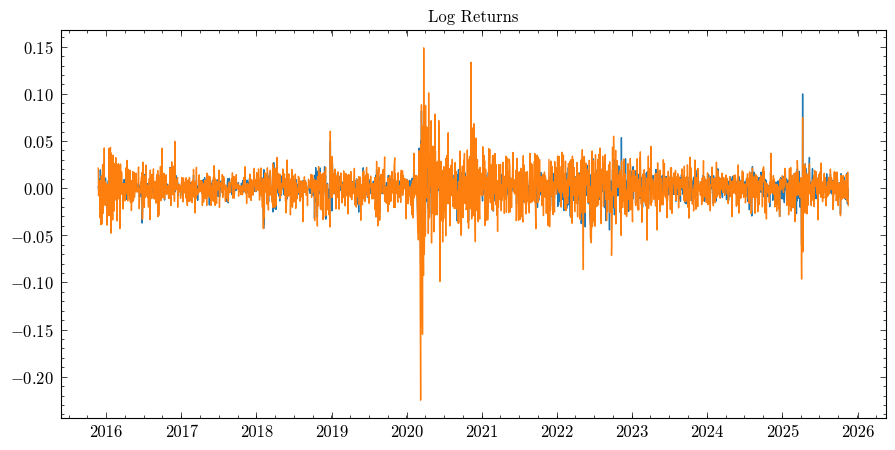

In [15]:
plt.figure(figsize=(10,5))
plt.title('Log Returns')
plt.plot(df['DATE'], df['SPY_r'])
plt.plot(df['DATE'], df['XLE_r'])

idiosyncratic volatility of XLE

In [16]:
X = df[['SPY_r']]   #
y = df['XLE_r']     

model = LinearRegression()
model.fit(X, y)


df['XLE_idio'] = y - model.predict(X)

In [17]:
df['XLE_idio_vol'] = transforms.realized_vol(df['XLE_idio'], window=7)

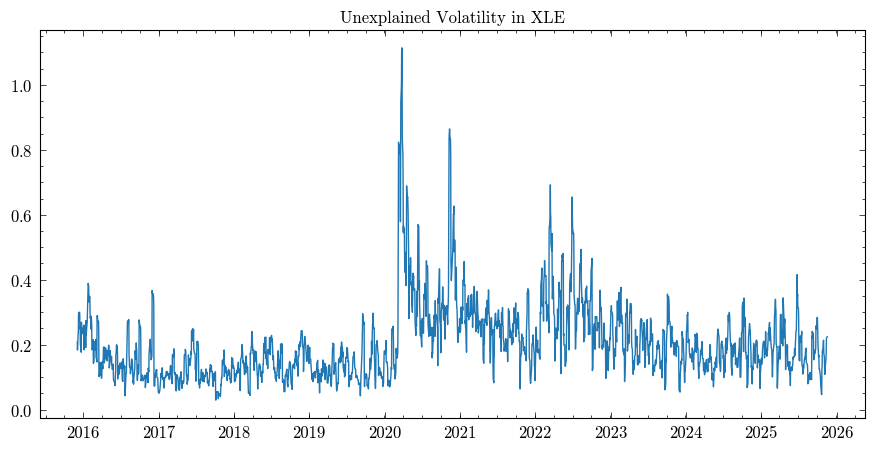

In [18]:
plt.figure(figsize=(10,5))
plt.title('Unexplained Volatility in XLE')
plt.plot(df['DATE'], df['XLE_idio_vol'] )

In [19]:
len(df)

2510

## Training

drop rows lost from rolling window

In [67]:
analysis = df.copy().dropna(subset=['XLE_idio_vol'])

In [69]:
train_size = .8
n = len(analysis)
n_rows = int(train_size * n)
TRAIN = analysis.iloc[: n_rows]

In [70]:
train_X = transforms.enforce_stationarity(TRAIN[macro]) # enforce stationary exogenous features
train_y = TRAIN['XLE_idio']    # garch input
train_y_vol = TRAIN['XLE_idio_vol'] # true target


### Feature Selection

In [57]:
selected_features, history_df = greedy_feature_selection(
    model=GARCHRegressor,
    model_params={'returns': train_y, 'p': 1, 'q': 1},
    X=train_X,
    y=train_y_vol, 
)

Initial qlike (no features): 3.9133024174145272
Step 1: added DCOILWTICO_d1, qlike = 3.0070337075717903
Step 2: added DGS10_d1, qlike = 2.9325593620748367
Step 3: added DHHNGSP_d0, qlike = 2.881963721806689


### Hyper Parameter Tuning

In [71]:
selected_exog = ['DCOILWTICO', 'DGS10', 'DHHNGSP']

In [72]:
train_X = transforms.enforce_stationarity(TRAIN[selected_exog]) # enforce stationary exogenous features
train_y = TRAIN['XLE_idio']    # garch input
train_y_vol = TRAIN['XLE_idio_vol'] # true target


### GARCH

In [ ]:
param_grid = {
    'returns': train_y,
    "p": [1, 2, 3],
    "q": [1, 2, 3],
    "mean_lags": [0, 1, 2, 3],
    "include_mean": [True, False],
}

best_params_garch, best_score_garch, all_scores_garch = ts_hyperparam_search(
    model_cls=GARCHRegressor,
    y=train_y_vol,   # full series for CV
    X=train_X,
    param_grid=param_grid,
    train_size=0.8,
    horizon=1,      
    verbose=True,
)


best parameters

In [ ]:
print(f"Best Parameters for GARCH: {best_params_garch}")
print(f"Best Score for GARCH: {best_score_garch}"})

### ARIMA

In [ ]:
param_grid = {
    "p": [1, 2, 3],
    "q": [1, 2, 3]
}

best_params_arima, best_score_arima, all_scores_arima = ts_hyperparam_search(
    model_cls=ARIMA_RV_Model,
    y=train_y_vol,   # full series for CV
    X=train_X,
    param_grid=param_grid,
    train_size=0.8,
    horizon=1,      
    verbose=True,
)


In [ ]:
print(f"Best Parameters for arima: {best_params_arima}")
print(f"Best Score for arima: {best_score_arima}"})

### XGBOOST

In [74]:
param_grid = {
    "max_depth": [3, 4],
    "learning_rate": [0.03, 0.05],
    "n_estimators": [300, 500],
    "subsample": [0.8, 1.0],
}

best_params_xgboost, best_score_xgboost, all_scores_xgboost = ts_hyperparam_search(
    model_cls=XGBRVModel,
    y=train_y_vol,   # full series for CV
    X=train_X,
    param_grid=param_grid,
    train_size=0.8,
    horizon=1,      
    verbose=True,
)



[1/16] params={'max_depth': 3, 'learning_rate': 0.03, 'n_estimators': 300, 'subsample': 0.8}, score=0.271868
[2/16] params={'max_depth': 3, 'learning_rate': 0.03, 'n_estimators': 300, 'subsample': 1.0}, score=0.275231
[3/16] params={'max_depth': 3, 'learning_rate': 0.03, 'n_estimators': 500, 'subsample': 0.8}, score=0.285574
[4/16] params={'max_depth': 3, 'learning_rate': 0.03, 'n_estimators': 500, 'subsample': 1.0}, score=0.290119
[5/16] params={'max_depth': 3, 'learning_rate': 0.05, 'n_estimators': 300, 'subsample': 0.8}, score=0.289566
[6/16] params={'max_depth': 3, 'learning_rate': 0.05, 'n_estimators': 300, 'subsample': 1.0}, score=0.290452


KeyboardInterrupt: 

In [ ]:
print(f"Best Parameters for xgboost: {best_params_xgboost}")
print(f"Best Score for xgboost: {best_score_xgboost}"})

## Testing